In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
from jupyter_plotly_dash import JupyterDash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import numpy as np
import os
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
from sys import exc_info
from caiman import movie as cmovie
import json
import pickle

%load_ext autoreload
%autoreload 2

from islets.Recording import Recording
from islets.Regions import Regions
from islets.utils import getFigure, showRoisOnly
from islets.numeric import rebin

import pandas as pd
from dash import no_update

In [2]:
if "srdjan" not in os.getcwd():
    os.chdir(os.path.expanduser("~"))

outputStyle = {
    "color":"navy",
    "font-family":"Courier New",
    "font-size":"80%",
    }
infoStyle = {
    "font-size":"80%",
    "color":"grey",
    }
bodyStyle = {
    }

baseFig = getFigure(w=200,h=150)

## global vars
test = "srdjan" in os.getcwd()
debug = "srdjan" in os.getcwd()

if test:
    %config InlineBackend.figure_format = 'retina'

from plotly.colors import DEFAULT_PLOTLY_COLORS

In [3]:
def tryexcept(x,default):
    try:
        return eval(x)
    except:
        return default

In [4]:
timescales = [.3,.4,.5,.7]+sorted([i*j for i in [1,2,3,4,5,7] for j in [1,10]])[:-3]+ sorted([i*j*60 for i in [1,1.5,2,3,5] for j in [1]])
timescales = np.array(timescales)
markerDict = { .3: "ultrafast",2:"fast",30:"slow",np.inf:"raw"}

In [5]:
allRecs = sorted([os.path.join(cur,f) for cur,ds,fs in os.walk("/data") for f in fs if f.endswith(".lif") or f.endswith(".nd2")])
allRecs = [f for f in allRecs if os.path.isfile(f.replace(os.path.split(f)[1],"."+os.path.split(f)[1]+".meta"))]

In [32]:
exampleLif = "/data/Sandra/2020/2020_06_22/Series003.nd2"

In [33]:
app = JupyterDash(__name__,
                  width=1200,
                  height=3000,
                 )

filterSlider = dcc.Slider(
                    id = "filter-slider",
                    min=0,
                    max=len(timescales),
                    value=len(timescales),#int(np.where(timescales>=3)[0][0]),
                    marks = {tryexcept(f"int(np.where(timescales>={ts})[0][0])",len(timescales)):{"label":markerDict[ts]} for ts in markerDict},
#                     marks={int(i_ultrafast): {"label":"ultrafast"},
#                            int(i_fast)     : {"label":"fast"},
#                            i_slow     : {"label":"slow"},
#                            (len(timescales)-1):{"label":"raw"}
#                           },
                    updatemode='drag',
                    )
SelectedRoisHidden = html.Div([
    html.Div([
           "Selected ROIs:",
            dcc.Input(id="selected-rois",
                type="text",
                debounce=False,
                size=6,
                value="",
             ), 
            html.Button("Calc all Peaks",id="calc-peaks"),
            html.Button("Refresh selector",id="selector-button"),
            html.Div("",id="calc-peaks-feedback"),
        ],style={"display": "inline-box" if debug else "none",**infoStyle}),

        html.Button('Discard unselected', id='discard-button', style={"display":"inline-box"},
                    n_clicks=1),
        html.Div(id="discard-feedback",children="",
             style={"display":"inline-box",**outputStyle,}
            )])
# CalcPeaksButtonHidden = html.Div(html.Button("Calc all Peaks",id="calc-peaks"),style={"display": "inline-box" if debug else "hidden"})

rangePickers = html.Div([dcc.RangeSlider(
                    id = "range-slider-%i"%i,
                    min=0.,
                    max=1.,
                    value=[0.02,.98] if i==0 else [0,0],
                    updatemode='mouseup',
                    included=True,
                    step=.001,
                    ) for i in range(3)],
                    style={"width":560, "padding-left":55})

SaveRasterDiv = html.Div([
    html.Div("Input the frequency at which to save raster and press enter",style=bodyStyle),
    dcc.Input(id="raster-freq", size="10px", style={"margin-left":"20px"}),
    html.Div(id="raster-save-feedback",style=outputStyle)
])

APP_LAYOUT = [
    
    html.H1(children='CTN Analytics',style=bodyStyle),
    html.Div("how do you like the name? :-)",style=infoStyle),
    html.Br(),
    ####################################
    html.Div('Select the experiment',style={**bodyStyle, "display":"inline-box"}),
    dcc.Dropdown(options = [{"value":path,"label":path} for path in allRecs], id="filepath-dropdown", value = exampleLif if (test and exampleLif in allRecs) else None, style={**bodyStyle,"width":"70%"}),
    html.Div('Select the series',style={**bodyStyle, "display":"inline-box"}),
    dcc.Dropdown(options = [{"value":None,"label":None}], id="series-dropdown", style={**bodyStyle,"width":"70%"}),
    html.Div([
        html.Div([
            'Select filer size',
            dcc.RadioItems(options = [{"value":None,"label":None}], id="pickle-radio", labelStyle={"display":"block"})
        ],style={**bodyStyle, "display":"inline-block", "vertical-align":"text-top"}),
        html.Div(id="pickle-previews", children = ["None"],style={"display":"inline-block","padding-left":"20px","vertical-align":"text-top",}),
    ],style={"padding-top":"20px"}),
    html.Div(id="pickle-feedback",style={**outputStyle}),
       
]
APP_LAYOUT += [html.Div([
        html.Div([
            k if debug else None,
            {"roi-selector":filterSlider}.get(k),
            dcc.Graph(id=k, figure=getFigure(300,400)),
            {
#                 "spike-durations":filterSlider,
                "roi-selector":SelectedRoisHidden,
                "range-pickers":rangePickers,
                "raster":SaveRasterDiv
            }.get(k)
                 ],style={"max-width":"550px","max-height":"550px","border":"thin grey solid" if debug else "none",}
                ) for k in ks
    ],
        style={"display":"flex", "flex-wrap":"wrap","align-items":"top","flex-shrink":3}
    ) for ks in [["roi-selector","range-pickers"],["spike-durations","raster"],["roi-hover"]*int(debug)]]

In [34]:
# callbacks
@app.callback(
    [Output("series-dropdown","value"),
    Output("series-dropdown","options")],
    [Input("filepath-dropdown","value")]
)
def serve_series(pathToRec):
    if pathToRec is None:
        return no_update
    if len(pathToRec)==0:
        return no_update
    analysisFolder = pathToRec+"_analysis"
    opts = [{"value":os.path.join(analysisFolder,el), "label":el} for el in sorted(os.listdir(analysisFolder)) if os.path.isdir(os.path.join(analysisFolder,el))]
    global pathToSer
    pathToSer = (opts[0]["value"] if len(opts) and test else None)
    return pathToSer, opts

@app.callback(
    [Output("pickle-radio","value"),
     Output("pickle-radio","options"),
     Output("pickle-previews","children")
    ],
    [Input("series-dropdown","value")]
)
def serve_pickles(pathToSer,width=200, height=200):
    import base64
    from collections import OrderedDict 
    if pathToSer is None:
        return no_update
    if len(pathToSer)==0:
        return no_update
    preview = OrderedDict()
    options = []
    for f in sorted(os.listdir(pathToSer))[::-1]:
        if f.endswith("pkl"):
            k = f.split("_")[0].replace(".","+")
            pathToRoi = os.path.join(pathToSer,f)
            options += [{ "label": k, "value": pathToRoi }]
            previewFile = pathToRoi.replace(f,".image_"+f.replace("_rois.pkl",".png"))
            if os.path.isfile(previewFile):
                encoded_image = base64.b64encode(open(previewFile, 'rb').read())
                preview[k] = html.Img(src='data:image/png;base64,{}'.format(encoded_image.decode()), width="%ipx"%(width*.9),height="%ipx"%(height*.8+20))

    if len(options) and test:
        val = options[0]["value"]
    else:
        val = None
    previews = [html.Div(children=[html.Div(k,style={"padding-left":"20px"}), preview[k]], style=dict(
        height="%ipx"%height,
        width="%ipx"%width,
        display="inline-block",
        border='thin lightgrey solid' 
    )) for k in preview]
    return val, options, html.Div(previews,style={"width":"%ipx"%(width*4.1)})

    

In [35]:
@app.callback(
    [Output("pickle-feedback","children"),
#      Output("roi-selector","figure"),
     Output("selector-button","n_clicks"),
     Output("calc-peaks","n_clicks"),
    ],
    [Input("pickle-radio","value")]
)
def import_pickle(path):
    if debug:
        global globpath, trend
        globpath = path
    if path is None:
        return no_update
    if len(path)==0:
        return no_update
    global regions
    from islets.numeric import mydebleach
    from islets.utils import multi_map
    with open(path,"rb") as f:
        regions = pickle.load(f)
    regions.update()
    regions.detrend_traces()
    regions.infer_gain()
    feedback = [
        "Regions imported successfully.",
        "Original movie:",
        html.Div(children=[
            "dimension (T,X,Y): (%i, %i, %i)"%((len(regions.time), )+regions.image.shape),
            html.Br(),
            "duration (h:m:s): "+str(pd.Timedelta(regions.time.max(), unit="s")).split()[-1].split(".")[0],
            html.Br(),
            "frequency (Hz): %.3g"%regions.Freq,
        ],style={'padding-left': '30px'}),
        "Number of ROIs: %i"%len(regions.df),
    ]
    feedback = sum([[el, html.Br()] for el in feedback],[])
#     roisImage = showRoisOnly(regions,indices=regions.df.index, im=regions.statImages[regions.mode])
#     return feedback,roisImage,1
    return feedback,1,1

In [36]:
@app.callback(
     Output("roi-selector","figure"),
    [Input("selector-button","n_clicks"),
     Input("discard-button","n_clicks"),
    ]
)
def plot_roi_selector(n_clicks1, n_clicks2):
    if n_clicks1>0 or n_clicks2>0:
        global regions
#         from Automatic1 import showRoisOnly as oldshowRoisOnly
        roisImage = showRoisOnly(regions,indices=regions.df.index, im=regions.statImages[regions.mode])
#         roisImage = oldshowRoisOnly(regions,indices=regions.df.index, im=regions.statImages[regions.mode])
        roisImage.update_layout({"dragmode":'lasso'},)
        return roisImage
    else:
        return no_update

In [37]:
@app.callback(
    Output("selected-rois", "value"),
    [Input("roi-selector", "selectedData")],
    )
def showSelected(selData):
#     return json.dumps(selData)
    if selData is None:
        return "all"
    ix = np.array( [p["hovertext"] for p in selData["points"]]).astype(int)
    ix = np.unique(ix)
    return ",".join(ix.astype(str))

In [38]:
@app.callback(
    Output("range-pickers", "figure"),
   [Input("selected-rois", "value"),
    Input("filter-slider", "value")]+[Input(rp.id, "value") for rp in rangePickers.children],
    )
def showTrace(selData,filtID,*ranges,showFreq = 5):
    global regions
    if debug:
        global t,y
    if selData is None:
        return baseFig
    if selData=="all":
        indices = regions.df.index
    else:
        indices = np.array(selData.split(",")).astype(int)
#     nRebin = int(regions.Freq/showFreq)
#     t = regions.time
#     t = regions.time
#     f = regions.Freq
#     if filtID<len(timescales):
#         ts = timescales[filtID]
#         if ts>regions.time[-1]/10:
#             k = "detrended"
#         else:
#             k = "faster_%g"%ts
#             if k not in regions.df:
#                 regions.fast_filter_traces(ts,z_sp=0)
#             try:
#                 t = regions.showTime["%g"%ts]
#                 f = t[1]-t[0]
#             except: 
#                 pass
#     else:
#         k = "trace"
            
#     print (k)
    k = "trace"
    t = regions.time
    f = regions.Freq
    y = np.sum([regions.df.loc[i,k]*regions.df.loc[i,"size"] for i in indices],axis=0)/regions.df["size"].sum()
    nRebin = int(f/showFreq)
    if nRebin>1:
        y = rebin(y, nRebin)
        t = rebin(t, nRebin)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t,y=y, line_width=.5, opacity=1, line_color="darkred"))
    ranges = [sorted(r) for r in ranges]
    ranges = [np.array(r)*(t[-1]-t[0])+t[0] if r[1]-r[0]>.01 else [0,1] for r in ranges ]
    fig.update_layout(
        shapes = [
            dict(
                type="rect",
                # x-reference is assigned to the x-values
                xref="x",
                # y-reference is assigned to the plot paper [0,1]
                yref="paper",
                x0=r[0],
                y0=0,
                x1=r[1],
                y1=1,
                fillcolor=DEFAULT_PLOTLY_COLORS[i],
                opacity=0.3,
                layer="below",
                line_width=0,
            ) for i,r in enumerate(ranges)])
    fig.update_layout({
        "plot_bgcolor":"white",
        "width":600,
        "height":400,
        "xaxis":dict(
            mirror=True,
            ticks='outside',
            showline=True,),
#         "dragmode":'drawrect',
        "margin": dict(t=50,r=10)
    })
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, ticks="outside", ticklen=3, nticks=10, title="time [s]", gridcolor="lightgrey")
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, ticks="outside", ticklen=3, gridcolor="lightgrey")
#     dragmode=,
#     newshape_line_color='cyan',
#     title_text='Draw a path to separate versicolor and virginica'
    return fig#.show(config={'modeBarButtonsToAdd':['drawline',
#                                     'drawopenpath',
#                                     'drawclosedpath',
#                                     'drawcircle',
#                                     'drawrect',
#           `                          'eraseshape'
#                                    ]})

In [39]:
@app.callback(
     Output("discard-feedback", "children"),
    [Input("discard-button",   "n_clicks")],
    [State("selected-rois", "value")]
             )
def discard_callback(n_clicks,selected):
    if n_clicks <= 0:
        return no_update
    global regions
    if selected == "":
        out = ""
    else:
        selectedIndices = np.unique(list(eval(selected)))
        nremoved = len(regions.df)-len(selectedIndices)
        regions.df = regions.df.loc[selectedIndices]
        out = "%i rois removed."%(nremoved)
    
    return out#, "all"

In [40]:
@app.callback(
    Output("spike-durations", "figure"),
    [Input("filter-slider", "value")]+[Input(rp.id, "value") for rp in rangePickers.children]
)
def plotPeakStats_callback(i, *ranges):
    timeScale = timescales[i]
    global regions
    k = "%g"%timeScale
    try:
        regions.peaks[k]
    except:
        regions.calc_peaks(timeScale)
    t0,te = regions.time[[0,-1]]
    ranges = [sorted(r) for r in ranges]
#     ranges = [r for r in ranges if r[1]!=r[0]]
    ranges = np.array(ranges)*(te-t0)+t0
    trfig = regions.show_scatter_peaks(timeScale, ranges)
    return trfig

In [41]:
@app.callback(
    Output("raster", "figure"),
    [Input("filter-slider", "value")]
)
def plotRaster_callback(i, npoints = 1000):
    global regions
    try:
        if i<len(timescales):
            timeScale = timescales[i]
        else:
            return baseFig
        rr, fig = regions.peaks2raster(timeScale, onlyRaster=False)
        return fig
    except:
        return baseFig

In [42]:
# app.layout = html.Div(children=APP_LAYOUT,
#                       style={"family":"Arial"}
#                      )
# app

In [43]:
app.layout = html.Div(children=APP_LAYOUT)
app._repr_html_() 
link2app = "https://ctn.physiologie.meduniwien.ac.at"+app.get_app_root_url()
HTML(f'open the following link in a different tab (do not close this tab!): <a href="{link2app}">{link2app}</a>')

# Rest

In [129]:
# i = regions.df.sort_values("size").index[len(regions.df)-1]
# i = regions.df.index[0]
# ts = 10
# regions.fast_filter_traces(ts,z_sp=0)
# plt.figure(figsize=(13,4))
# plt.plot(regions.time, regions.df['trace'].loc[i],lw=.5)
# plt.plot(regions.showTime["%g"%ts], regions.df['slower_%g'%ts].loc[i],lw=.5)

# regions.fast_filter_traces(ts,z_sp=2)
# plt.plot(regions.showTime["%g"%ts], regions.df['slower_%g'%ts].loc[i],lw=.5)

# plt.figure(figsize=(13,4))
# plt.plot(regions.showTime["%g"%ts], regions.df['zScore_%g'%ts].loc[i])

In [8]:
pathToPickle = '/data/Sandra/2020/2020_06_22/Series014.nd2_analysis/all/7_rois.pkl'

In [9]:
import_pickle(pathToPickle)

(['Regions imported successfully.',
  Br(None),
  'Original movie:',
  Br(None),
  Div(children=['dimension (T,X,Y): (16976, 256, 256)', Br(None), 'duration (h:m:s): 00:09:24', Br(None), 'frequency (Hz): 30.1'], style={'padding-left': '30px'}),
  Br(None),
  'Number of ROIs: 281',
  Br(None)],
 1,
 1)

In [15]:
import matplotlib.pyplot as plt

In [16]:
plt.hexbin?

Nrebin = 3


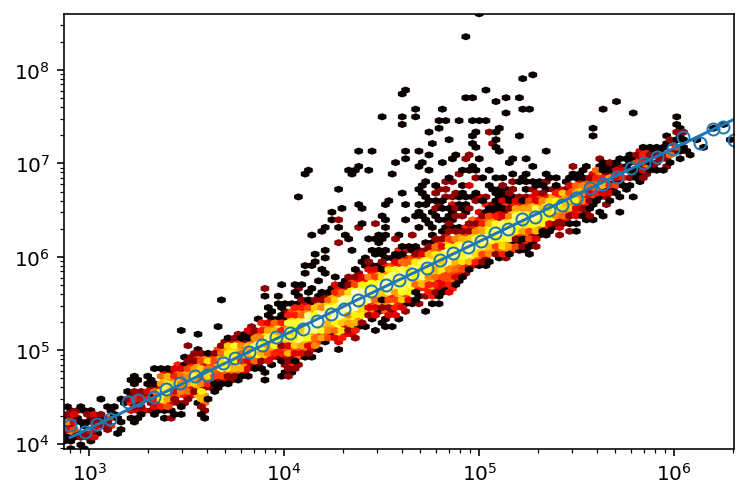

In [20]:
regions.infer_gain(plot=True)

In [21]:
regions.gain

14.593940762878221

Nrebin = 6
5
Nrebin = 6


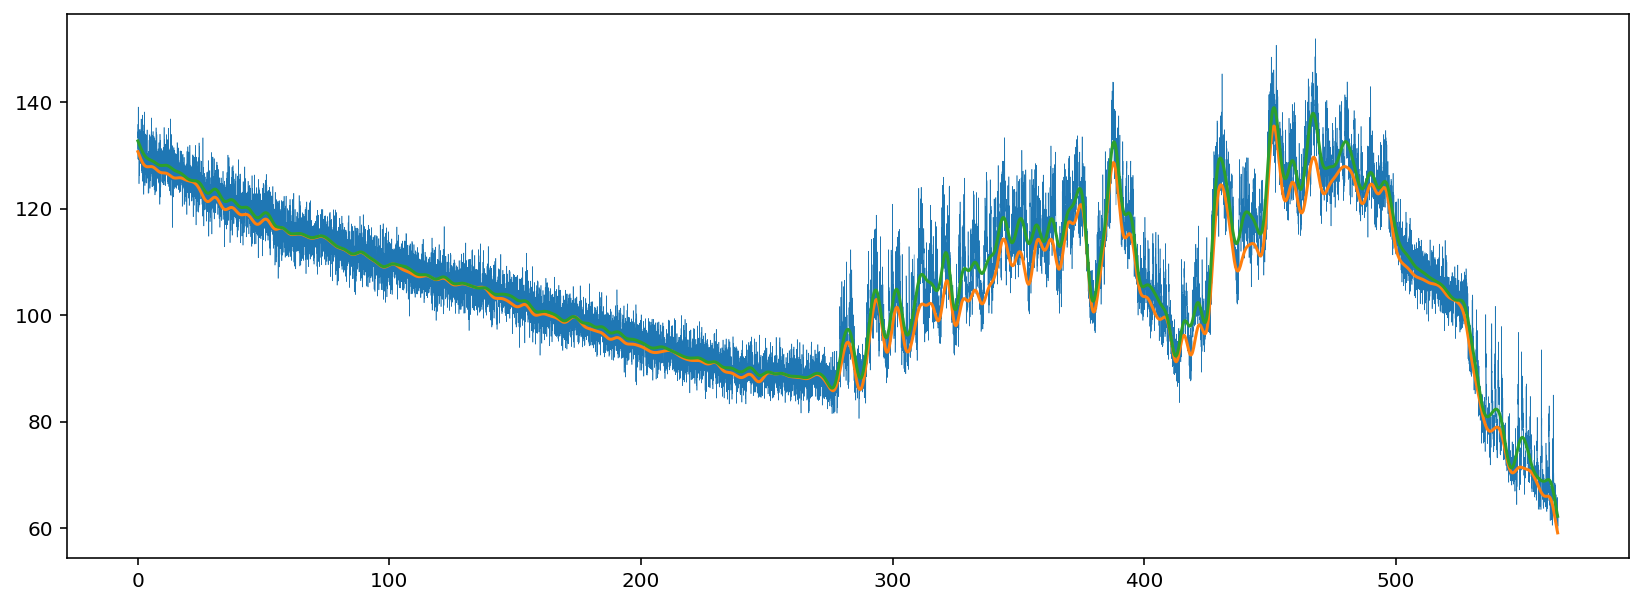

In [31]:
plt.figure(figsize=(14,5))
i = 0
plt.plot(regions.time, regions.df["trace"][i], lw=.3)
regions.fast_filter_traces(3)
plt.plot(regions.showTime["3"], regions.df["slower_3"][i])
regions.fast_filter_traces(3,z_sp=0)
plt.plot(regions.showTime["3"], regions.df["slower_3"][i])
# plt.plot(regions.showTime["3"], regions.df["faster_3"][0])

Nrebin = 6
5
Nrebin = 6


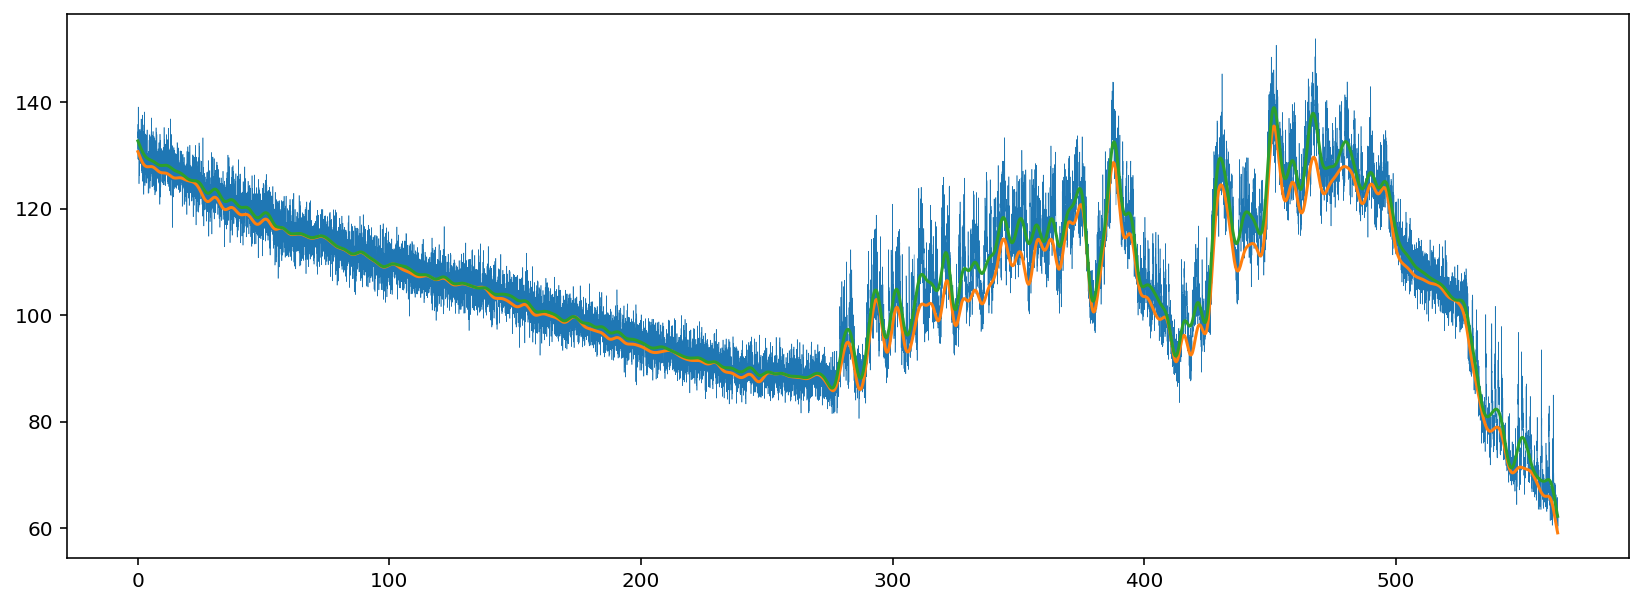

In [31]:
plt.figure(figsize=(14,5))
i = 0
plt.plot(regions.time, regions.df["trace"][i], lw=.3)
regions.fast_filter_traces(3)
plt.plot(regions.showTime["3"], regions.df["slower_3"][i])
regions.fast_filter_traces(3,z_sp=0)
plt.plot(regions.showTime["3"], regions.df["slower_3"][i])
# plt.plot(regions.showTime["3"], regions.df["faster_3"][0])

In [96]:
regions.df.columns

Index(['peak', 'pixels', 'trace', 'size', 'interest', 'edges', 'boundary',
       'neighbors', 'Nneighbors', 'trend', 'detrended'],
      dtype='object')

In [98]:
regions.df.trace[0].shape, regions.df.detrended[0].shape, regions.time.shape

((16976,), (16976,), (16976,))

In [157]:
%%capture tmp
ts = 1
regions.fast_filter_traces(ts,z_sp=0)

In [158]:
exec(tmp.stdout[:-1])
Nrebin

2

In [159]:
C = regions.df

In [160]:
absFast = np.vstack([C.loc[i,"faster_%g"%ts]*C.loc[i,"size"] for i in C.index])*Nrebin
absSlow = np.vstack([C.loc[i,"slower_%g"%ts]*C.loc[i,"size"] for i in C.index])*Nrebin

In [ ]:
def infer_gain(regions):
    

    absSlow, absFast = regions.fast_filter_traces(ts,write=False)

In [171]:
di = 30
slow_est, fast_vars = [],[]
for i in range(absFast.shape[0]):
    for j in range(di, absFast.shape[1]-di, absFast.shape[1]//30):
        slow_est  += [absSlow[i,j]]
        fast_vars += [absFast[i,j-di:j+di].var()]

In [172]:
fast_vars = np.array(fast_vars)
slow_est = np.array(slow_est)

In [173]:
import matplotlib.pyplot as plt
if test:
    %config InlineBackend.figure_format = 'retina'

In [174]:
from sklearn.linear_model import LinearRegression

In [175]:
# logbs = np.percentile(np.log(slow_est),np.linspace(0,100))
logbs = np.log(np.logspace(np.log10(slow_est.min()),np.log10(slow_est.max())))
d = np.digitize(np.log(slow_est), logbs)
x = np.array([slow_est[d==i].mean() for i in np.unique(d)])
y = np.array([np.median(fast_vars[d==i]) for i in np.unique(d)])

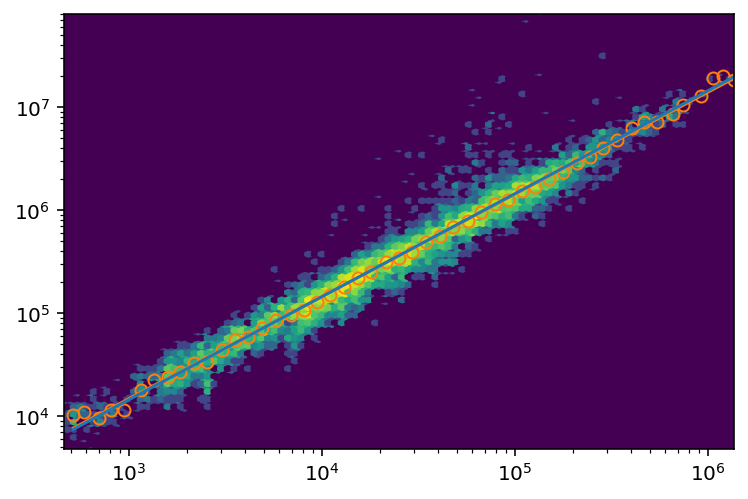

In [179]:
ax = plt.subplot(111)
ax.hexbin(slow_est, fast_vars, bins="log",
          xscale="log",
          yscale="log"
         )
plt.plot(x,y,"C1o",mfc="none")

lrlog = LinearRegression(fit_intercept=True)
lrlog.fit(np.log(x).reshape(-1,1), np.log(y))
plt.plot(x,np.exp(lrlog.predict(np.log(x).reshape(-1,1))),"C1")

gain = np.mean(y/x)
plt.plot(x,x*gain)

# lrlin = LinearRegression(fit_intercept=False)
# lrlin.fit(x.reshape(-1,1), y)
# plt.plot(x,lrlin.predict(x.reshape(-1,1)),"C2")


# # ax.set_aspect("equal")
# # ax.plot(slow_est,slow_est,"C1")

In [147]:
lrlog.intercept_, lrlog.coef_

(2.754304727370126, array([0.99197541]))

In [148]:
pathToPickle

'/data/Sandra/2020/2020_06_22/Series014.nd2_analysis/all/7_rois.pkl'

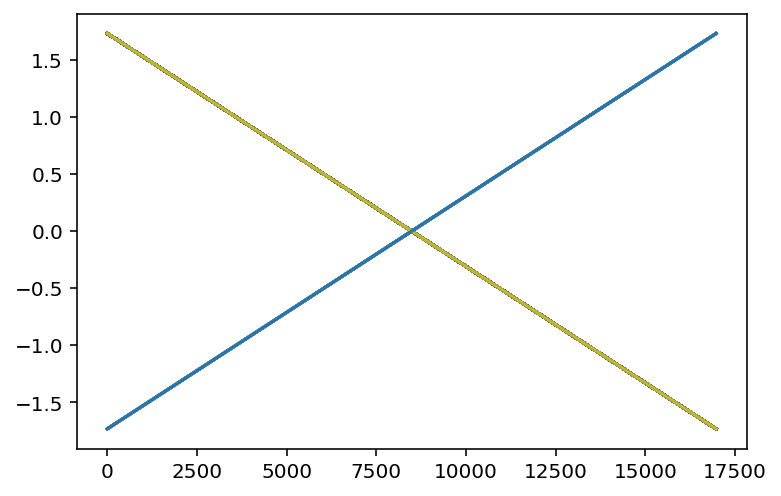

In [121]:
for i in C.index:
    x = C.loc[i,"trend"].copy()
    plt.plot((x-x.mean())/x.std())

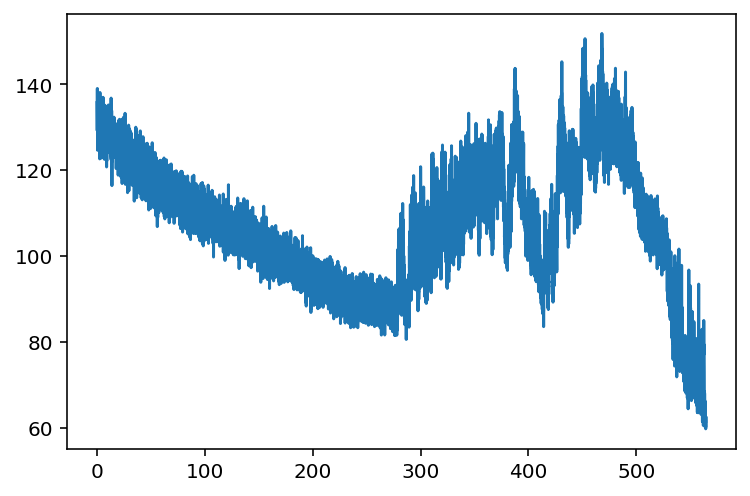

In [119]:
plt.plot(regions.time, C.trace[0])

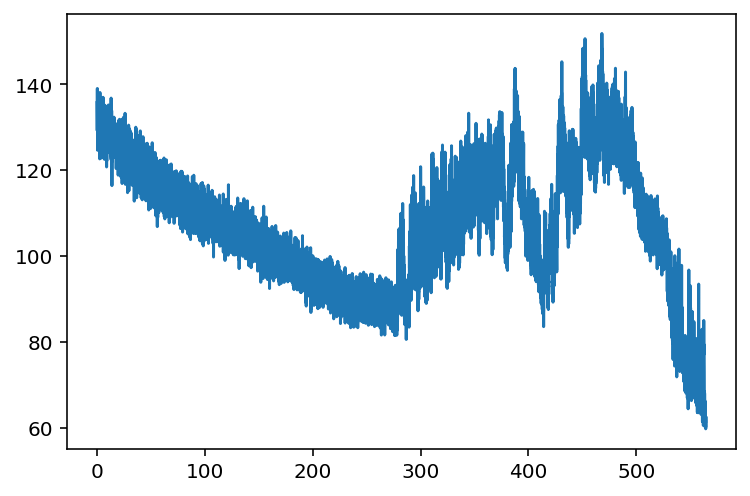

In [83]:
plt.plot(regions.time, C.raw_trace[0])

In [652]:
regions.fast_filter_traces(ts, meanSlow2Var = lambda xi: np.exp(lrlog.predict(np.log(xi.flatten()).reshape(-1,1))).reshape(xi.shape),
                           z_sp=np.inf)
x = C.loc[i,"slower_%g"%ts].copy()
regions.fast_filter_traces(ts, meanSlow2Var = lambda xi: np.exp(lrlog.predict(np.log(xi.flatten()).reshape(-1,1))).reshape(xi.shape),
                           z_sp=1)
y = C.loc[i,"slower_%g"%ts].copy()

Nrebin = 26
Nrebin = 26
5


In [ ]:
regions.

In [8]:
pathToPickle = '/data/Sandra/2020/2020_06_22/Series014.nd2_analysis/all/7_rois.pkl'

In [9]:
import_pickle(pathToPickle)

(['Regions imported successfully.',
  Br(None),
  'Original movie:',
  Br(None),
  Div(children=['dimension (T,X,Y): (16976, 256, 256)', Br(None), 'duration (h:m:s): 00:09:24', Br(None), 'frequency (Hz): 30.1'], style={'padding-left': '30px'}),
  Br(None),
  'Number of ROIs: 281',
  Br(None)],
 1,
 1)

In [15]:
import matplotlib.pyplot as plt

In [16]:
plt.hexbin?

Nrebin = 3


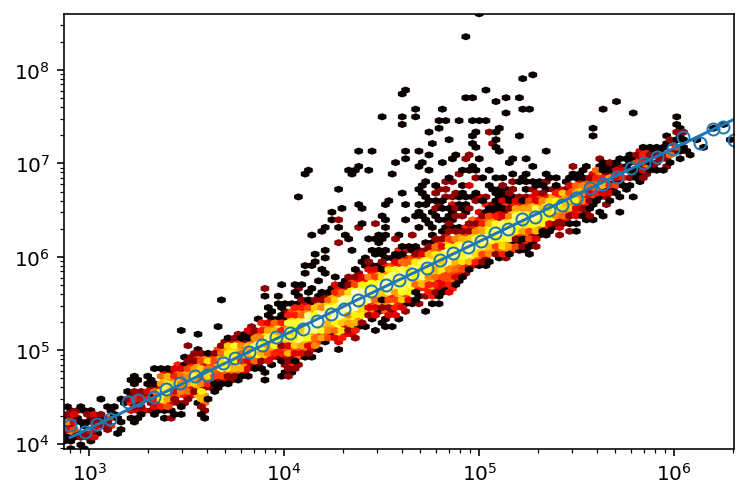

In [20]:
regions.infer_gain(plot=True)

In [21]:
regions.gain

14.593940762878221

Nrebin = 6
5
Nrebin = 6


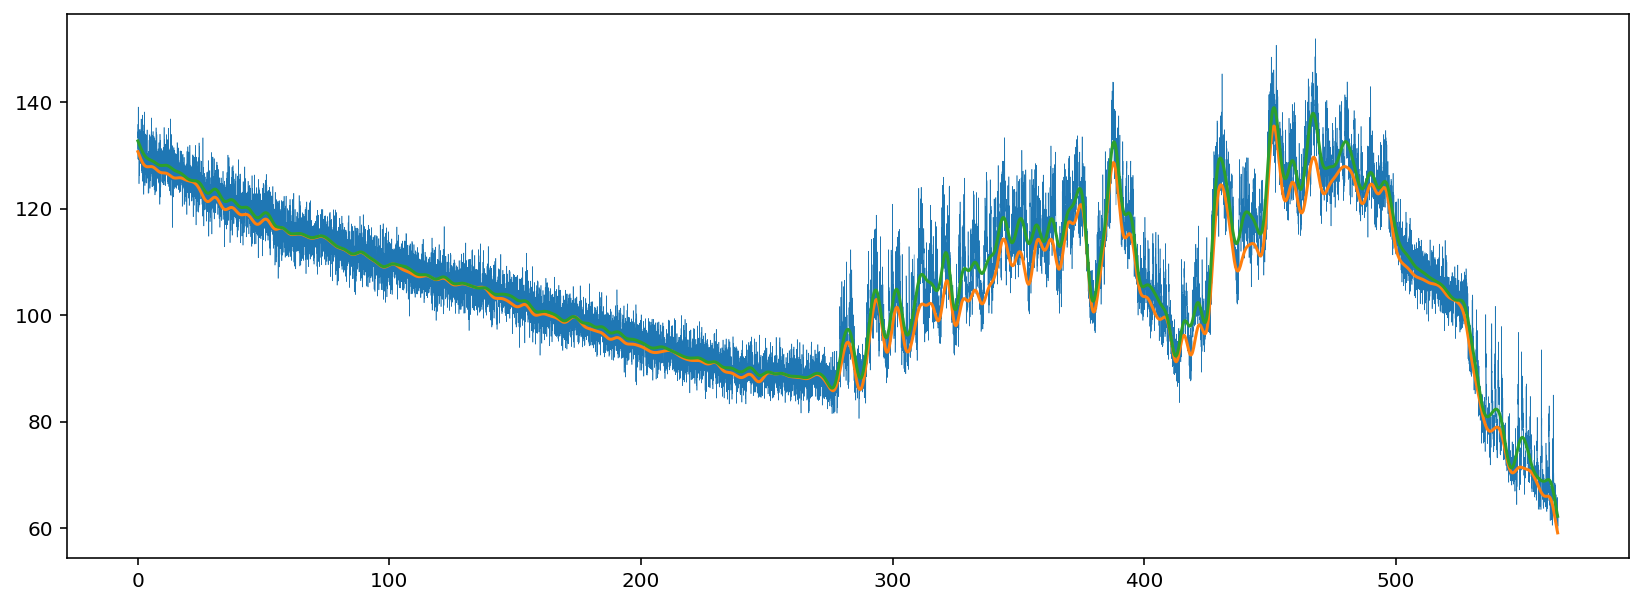

In [31]:
plt.figure(figsize=(14,5))
i = 0
plt.plot(regions.time, regions.df["trace"][i], lw=.3)
regions.fast_filter_traces(3)
plt.plot(regions.showTime["3"], regions.df["slower_3"][i])
regions.fast_filter_traces(3,z_sp=0)
plt.plot(regions.showTime["3"], regions.df["slower_3"][i])
# plt.plot(regions.showTime["3"], regions.df["faster_3"][0])

# Rest

In [342]:
allDF = []
for f in allRecs:
    folder,exp = os.path.split(f)
    if not os.path.isfile(f.replace(exp,"."+exp+".meta")): continue
    df = pd.read_csv(f.replace(exp, "."+exp+".meta"))
    df.rename(columns={"Unnamed: 0":"Ser_ID"})
    df = df.query("SizeT>10")
    df["Experiment"] = exp
    df["Path"] = f
    allDF += [df]
allDF = pd.concat(allDF,ignore_index=True)

In [343]:
allDF

,Unnamed: 0,Name,SizeT,SizeX,SizeY,pxSize,pxUnit,bit depth,Frequency,Start time,End time,Duration,Experiment,Path
0,0,Series003,7385,256,256,0.857,µm,uint8,9.89,2020-06-18 13:43:48,2020-06-18 13:56:14.807124239,0 days 00:12:26.807124239,Experiment54a.lif,/data/Sandra/2020_06_18/Experiment54a.lif
1,1,Series004,28132,128,128,1.530,µm,uint8,19.80,2020-06-18 14:09:14,2020-06-18 14:32:56.698572968,0 days 00:23:42.698572968,Experiment54a.lif,/data/Sandra/2020_06_18/Experiment54a.lif
2,0,Series001,8000,512,512,0.910,µm,uint8,19.80,2020-06-18 14:43:07,2020-06-18 14:49:51.860608949,0 days 00:06:44.860608949,Experiment54b.lif,/data/Sandra/2020_06_18/Experiment54b.lif
3,1,Series002,8000,512,512,0.910,µm,uint8,19.80,2020-06-18 14:49:52,2020-06-18 14:56:36.877609365,0 days 00:06:44.877609365,Experiment54b.lif,/data/Sandra/2020_06_18/Experiment54b.lif
4,2,Series003,71,512,512,0.910,µm,uint8,19.80,2020-06-18 14:56:38,2020-06-18 14:56:41.592599814,0 days 00:00:03.592599814,Experiment54b.lif,/data/Sandra/2020_06_18/Experiment54b.lif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,28,Series032,23873,256,256,1.240,µm,uint8,9.93,2015-11-16 15:31:42,2015-11-16 16:11:45.767689621,0 days 00:40:03.767689621,ExperimentOGB.lif,/data/prototype/ExperimentOGB.lif
177,36,Series045,16294,256,256,1.030,µm,uint8,9.93,2015-11-16 17:02:31,2015-11-16 17:29:51.501680405,0 days 00:27:20.501680405,ExperimentOGB.lif,/data/prototype/ExperimentOGB.lif
178,43,Series054,21436,256,256,1.030,µm,uint8,9.93,2015-11-16 17:38:36,2015-11-16 18:14:34.358689828,0 days 00:35:58.358689828,ExperimentOGB.lif,/data/prototype/ExperimentOGB.lif
179,51,Series064,16381,256,256,1.010,µm,uint8,9.93,2015-11-16 18:22:03,2015-11-16 18:49:32.438691529,0 days 00:27:29.438691529,ExperimentOGB.lif,/data/prototype/ExperimentOGB.lif


In [368]:
allDF.query("Frequency>40").sort_values("Experiment").Experiment.values

array(['Experiment38a.lif', 'Experiment38a.lif', 'Experiment38a.lif',
       'Experiment38a.lif', 'Experiment38a.lif', 'Experiment38b.lif',
       'Experiment38b.lif', 'Experiment38b.lif', 'Experiment38b.lif',
       'Experiment38b.lif', 'Experiment38b.lif', 'Experiment38b.lif',
       'Experiment38b.lif', 'Experiment38b.lif', 'Experiment38b.lif',
       'Experiment39a.lif', 'Experiment39a.lif', 'Experiment39a.lif',
       'Experiment39a.lif', 'Experiment39a.lif', 'Experiment39a.lif',
       'Experiment39b.lif', 'Experiment39b.lif', 'Experiment39b.lif',
       'Experiment39c.lif', 'Experiment39c.lif', 'Experiment39c.lif',
       'Experiment39d.lif', 'Experiment39d.lif', 'Experiment39d.lif',
       'Experiment39e.lif', 'Experiment39f.lif', 'Experiment39f.lif',
       'Experiment48b.lif', 'Experiment48b.lif', 'Experiment48b.lif',
       'Experiment48b.lif', 'Experiment48b.lif', 'Experiment48b.lif',
       'Experiment49a.lif', 'Experiment49a.lif', 'Experiment49b.lif',
       'Experiment49

In [347]:
protocols = pd.read_csv("/home/jupyter-srdjan/protocols.csv")

In [348]:
protocols.columns

Index(['date', 'experiment', 'microscope', 'magnification', 'frequency',
       'resolution', 'mouse', 'sex', 'pH', 'glucose', 'treatment', 'comments',
       'Slice number', 'dye', 'part of pancreas'],
      dtype='object')

In [359]:
protocols["glucose"] = pd.to_numeric(protocols["glucose"], errors="coerce")

In [371]:
protocols.query("microscope!='Nikon' and glucose==8").sort_values("experiment").iloc[-50::]

,date,experiment,microscope,magnification,frequency,resolution,mouse,sex,pH,glucose,treatment,comments,Slice number,dye,part of pancreas
73,2019_11_12,Experiment41b_Series035,Leica inverted,20x,NaN,512x512,NMRI,m,7.4,8.0,NaN,NaN,4.0,Calbryte-520,NaN
76,2019_11_12,Experiment41b_Series053,Leica inverted,20x,NaN,128x128,NMRI,m,7.4,8.0,NaN,NaN,7.0,Calbryte-520,NaN
80,2019_11_12,Experiment41b_Series089,Leica inverted,20x,NaN,128x128,NMRI,m,7.1,8.0,NaN,very nice,10.0,Calbryte-520,NaN
82,2019_11_12,Experiment41b_Series096,Leica inverted,20x,NaN,128x128,NMRI,m,7.7,8.0,NaN,very nice,11.0,Calbryte-520,NaN
55,2019_11_13,Experiment42a_Series004,Leica upright,20x,NaN,512x512,NMRI,f,NaN,8.0,pH changes (7.4 54-3827; 7.1 3827-5569; 7.7 55...,NaN,1.0,Calbryte-520,NaN
56,2019_11_13,Experiment42a_Series010,Leica upright,20x,NaN,512x512,NMRI,f,NaN,8.0,pH changes (7.4 39-3666; 7.7 3666-5421; 7.7 54...,NaN,2.0,Calbryte-520,NaN
58,2019_11_13,Experiment42b_Series019,Leica inverted,20x,NaN,128x128,NMRI,f,7.4,8.0,NaN,not good,2.0,Calbryte-520,NaN
60,2019_11_13,Experiment42b_Series029,Leica inverted,20x,NaN,128x128,NMRI,f,7.4,8.0,NaN,not good,3.0,Calbryte-520,NaN
62,2019_11_13,Experiment42b_Series040,Leica inverted,20x,NaN,128x128,NMRI,f,7.4,8.0,NaN,not good,4.0,Calbryte-520,NaN
34,2019_11_21,Experiment43a_Series008,Leica upright,20x,NaN,512x512,NMRI,m,NaN,8.0,pH changes (7.4 52-3744; 7.7 3744-5587; 7.1 55...,NaN,1.0,Calbryte-520,NaN
